
# ch06. 하이퍼 파라미터 튜닝과 모델 성능지표

## 파이프라인

In [8]:
## 연습용 데이터 적재 하기 
## 위스콘신 유방암 데이터세트 

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [9]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


0 열: 환자의 고유 아이디 넘버

1 열: 종양의 악성/양성 여부 (M =악성, B =양성) 

2~31 열: 세포 핵의 이미지로 부터 추출된 측성값 

In [95]:
pd.Series.value_counts(df.loc[:,1].values)

B    357
M    212
dtype: int64

불균형한 레이블을 갖는 데이터는 아님. 각 레이블에 해당하는 데이터 분포가 균등한 편.

In [ ]:
X = df.loc[:,range(2,32)].values
y = df.loc[:,1].values

In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y) 

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

타깃 변수 요인 변수로 바꾸고, train, test 세트로 분리 (test 세트 전체의 20%로 분리했음)

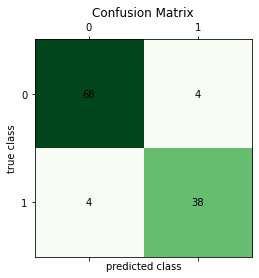

In [52]:
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipe_gc = make_pipeline(PCA(n_components=3),
                       GradientBoostingClassifier(n_estimators=500,random_state=1))

pipe_gc.fit(X_train,y_train)
y_pred = pipe_gc.predict(X_test)

confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)

fig, ax = plt.subplots()
ax.matshow(confmat, cmap = plt.cm.Greens)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=i,y=j,s=confmat[i,j], va='center',ha='center')

plt.title('Confusion Matrix')
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()


In [56]:
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_true=y_test,y_pred=y_pred)
recall = recall_score(y_true=y_test,y_pred=y_pred)

print('테스트 정확도: %.3f \n테스트 민감도: %.3f'%(accuracy,recall))

테스트 정확도: 0.930 
테스트 민감도: 0.905


먼저, 홀드 아웃 기법을 통해 모델을 세우고 예측을 해보았음. 

다음은 훈련세트를 k개의 폴드로 나누어서 교차검증을 실시함

## k-겹 교차검증

In [100]:
## from sklearn.model_selection import cross_val_score  ##cross_val_score 의 경우 accuracy 이외에는 실행이 잘 안됨

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(X_train,y_train)

accuracy_list =[]
recall_list = []

for k, (train, test) in enumerate(folds):
    pipe_gc.fit(X_train[train],y_train[train])
    y_pred = pipe_gc.predict(X_train[test])
    recall = recall_score(y_true=y_train[test],y_pred=y_pred)
    accuracy = accuracy_score(y_true=y_train[test],y_pred=y_pred)
    
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    print('%d번 폴드: \n정확도%.3f \n재현율: %.3f\n'%(k+1,accuracy,recall))


1번 폴드: 
정확도0.913 
재현율: 0.824

2번 폴드: 
정확도0.957 
재현율: 1.000

3번 폴드: 
정확도0.913 
재현율: 0.882

4번 폴드: 
정확도0.935 
재현율: 0.941

5번 폴드: 
정확도0.848 
재현율: 0.882

6번 폴드: 
정확도0.911 
재현율: 0.765

7번 폴드: 
정확도0.956 
재현율: 0.882

8번 폴드: 
정확도0.933 
재현율: 0.824

9번 폴드: 
정확도0.889 
재현율: 0.941

10번 폴드: 
정확도0.933 
재현율: 0.882



In [103]:
import numpy as np 

print('훈련세트 전체 평균 정확도: %.3f +/- %.3f,훈련세트 전체 평균 재현율: %.3f +/- %.3f'
      %(np.mean(accuracy_list),np.std(accuracy_list),np.mean(recall_list),np.std(recall_list)))

전체 평균 정확도: 0.919 +/- 0.031, 전체 평균 재현율: 0.882 +/- 0.064


In [104]:
y_pred = pipe_gc.predict(X_test)
test_accuracy = accuracy_score(y_true=y_test,y_pred=y_pred)
test_recall = recall_score(y_true=y_test,y_pred=y_pred)
print('테스트 세트 정확도: %.3f, 테스트 세트 재현율:%.3f'%(test_accuracy,test_recall))

테스트 세트 정확도: 0.947, 테스트 세트 재현율:0.929


훈련 세트에서 교차검증 때 보다 테스트 세트 에서 더 높은 성능을 보임. 

과대적합의 문제는 없어보임. 

다음은 최적의 하이퍼 파라미터 값을 찾아가며 그리드 서치를 수행하겠음. 



## 그리드 서치를 통한 하이퍼 파라미터 튜닝

In [106]:
pipe_gc.get_params() ## 튜닝할 하이퍼 파라미터 명을 찾음 

{'memory': None,
 'steps': [('pca', PCA(n_components=3)),
  ('gradientboostingclassifier',
   GradientBoostingClassifier(n_estimators=500, random_state=1))],
 'verbose': False,
 'pca': PCA(n_components=3),
 'gradientboostingclassifier': GradientBoostingClassifier(n_estimators=500, random_state=1),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 3,
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_leaf_nodes': None,
 'gradientboostingclassifier__min_impurity_decrease': 0.0,
 'gradientboostingclassifier__min_impurity_split': None,
 'gradientboos

In [135]:
from sklearn.model_selection import GridSearchCV

params = [{'gradientboostingclassifier__learning_rate':[0.001,0.01,0.1,1],
          'gradientboostingclassifier__n_estimators': [50,100,150,200,500],
          'gradientboostingclassifier__max_depth': [None,1,2,3]},]

gs = GridSearchCV(estimator=pipe_gc ,param_grid=params, scoring = 'accuracy',cv=10)

gs = gs.fit (X_train, y_train)

In [109]:
print('정확도: %.3f'%gs.best_score_)
print('정확도: %s'%gs.best_params_)

정확도: 0.925
정확도: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100}


In [113]:
clf = gs.best_estimator_

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print('테스트 세트 정확도: %.3f'%accuracy)

테스트 세트 정확도: 0.947


## ROC 곡선, 학습곡선, 검증곡선 그리기 

In [114]:
from sklearn.preprocessing import StandardScaler ## 로지스틱회귀는 데이터 스케일에 민감하므로 표준화 작업을 거치겠음
from sklearn.linear_model import LogisticRegression

pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(solver='liblinear',penalty='l2',random_state=1))

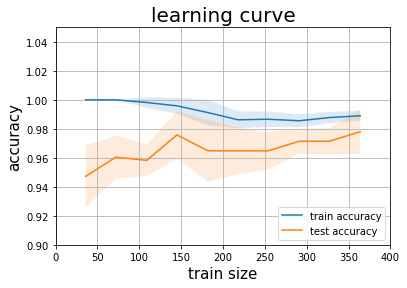

In [185]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, y=y_train,train_sizes=np.linspace(0.1,1.0,10), cv=5)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes,train_mean, label='train accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std, alpha=0.15)

plt.plot(train_sizes,test_mean, label='test accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15)

plt.ylim([0.9,1.05])
plt.xlim([0,400])
plt.legend(loc='lower right')
plt.xlabel('train size',fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.title('learning curve',fontsize=20)
plt.grid()
plt.show()


Text(0.5, 1.0, 'validation curve')

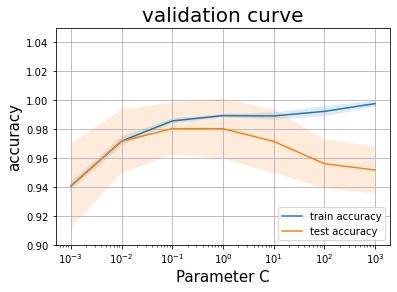

In [184]:
from sklearn.model_selection import validation_curve

param_range_n_estimator = [0.001,0.01,0.1,1,10,100,1000]

train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='logisticregression__C',
                                            param_range=param_range_n_estimator,cv=10)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range_n_estimator,train_mean, label='train accuracy')
plt.fill_between(param_range_n_estimator,train_mean+train_std,train_mean-train_std, alpha=0.15)
plt.plot(param_range_n_estimator,test_mean, label='test accuracy')
plt.fill_between(param_range_n_estimator,test_mean+test_std,test_mean-test_std, alpha=0.15)

plt.grid()
plt.legend(loc='lower right')
plt.xscale('log')
plt.ylim([0.9,1.05])
plt.xlabel('Parameter C',fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.title('validation curve',fontsize=20)



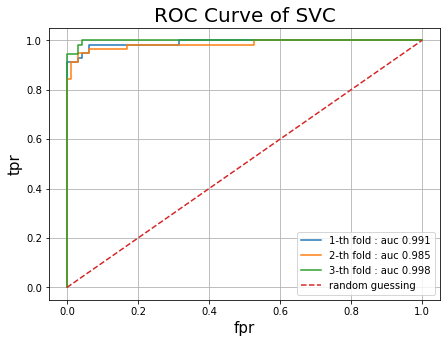

In [181]:
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve, auc

pipe_svc = make_pipeline(StandardScaler(),PCA(n_components=5),SVC(probability=True)) ##  SVC가 레이블 값이 아닌 확률값을 반환하도록 probability=False 명시

cv = list(StratifiedKFold(n_splits=3, shuffle=True,random_state=1).split(X_train, y_train))

plt.figure(figsize=(7,5))

for k, (train, test) in enumerate(cv):
    pipe_svc.fit(X_train[train],y_train[train])
    probas = pipe_svc.predict_proba(X_train[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%d-th fold : auc %.3f'%(k+1,auc_score))

plt.plot([0,1],[0,1], linestyle='--', label='random guessing')
plt.grid()
plt.xlabel('fpr', fontsize=15)
plt.ylabel('tpr',fontsize=15)
plt.title('ROC Curve of SVC', fontsize=20)
plt.legend(loc='lower right')
plt.show()
    
    

훈련 데이터의 각 폴드별 auc 점수와 함꼐 ROC 곡선을 그려보았다. 

auc 점수가 너무 높게 나온 것으로 보아 과대적합이 되었을 가능성이 있다. 

## 불균형한 클래스 다루기

In [190]:
## SMOTE 기법을 이용하여 불균형한 클래스의 클래스 별 데이터 갯수를 비슷하게 맞춰 주려함 
## 일단 임의로 불균형한 데이터를 생성 : 2개의 클래스를 가진 독립변수와 4개의 종속변수를 가진 데이터를 생성함 

from sklearn.datasets import make_classification
from collections import Counter

X, y = make_classification(n_samples=25000, weights=[0.99], n_features=4, n_classes=2,n_redundant=0, random_state=1)

counter = Counter(y)
print(counter)

Counter({0: 24609, 1: 391})


두 클래스가 9:1 비율로 매우 불균형한 데이터가 생성 

In [195]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X, y = smote.fit_resample(X, y)

counter = Counter(y)
print(counter)

Counter({0: 24609, 1: 24609})


SMOTE 기법을 통해 5:5의 비율로 레이블별 데이터 분포 비율을 맞춤